# DenseReg: Fully Convolutional Dense Shape Regression In-the-Wild


- First, setting up cv2, matplotlib, numpy, etc. 
- Load Caffe

Make sure that your path (my_caffe below) is correct.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
from scipy.io import loadmat
from PIL import Image
from scipy.misc import imresize
import copy

# Loading caffe !
import sys
sys.path.append("DeepLab-Context2/python")
import caffe

- Setting in gpu mode and selecting gpu
- Selecting deploy prototxt and trained DenseReg model.
- Create the net.

In [2]:
caffe.set_mode_gpu()
caffe.set_device(0)

deployFile= "model/deploy.prototxt"
caffemodel= "model/DenseReg_K10.caffemodel" # Model with $K=10$

net = caffe.Net(deployFile, caffemodel, caffe.TEST)
mean= (104.00699, 116.66877, 122.67892)


Load geometric information on the template space:

  - Coordinates of the Landmarks
  - A grid in the deformation-free coordinate system
  - Semantic Parts in the deformation-free coordinate system
  
and visualize them.
    

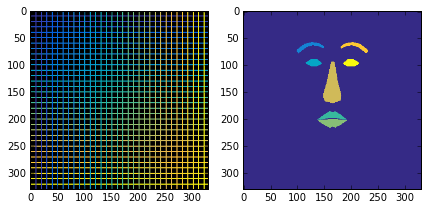

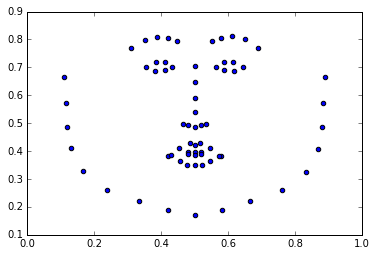

In [3]:
#Read Landmark Coordinates
template_landmarks = np.load('template_data/template_landmarks.npy')
#Read Segmentation Map
L =  loadmat('template_data/SegLabelsColor.mat')
L_segments_color = L['L_color']
# Read 
L =  loadmat('template_data/Grid_color.mat')
L_grid_color = L['Grid_color']

# Visualization
f, axarr = plt.subplots(1, 2, figsize=(7,7))
axarr[0].imshow(L_grid_color)
axarr[1].imshow(L_segments_color)

plt.figure(2)
plt.scatter(template_landmarks[:,0],template_landmarks[:,1])


Read an image, resize the image such that its size is $8K+1$, where $K$ is an intager (to keep the size after downsampling).

Make a forward pass with the image data as input.

Visualize the regressed coordinates $H$ and $V$.


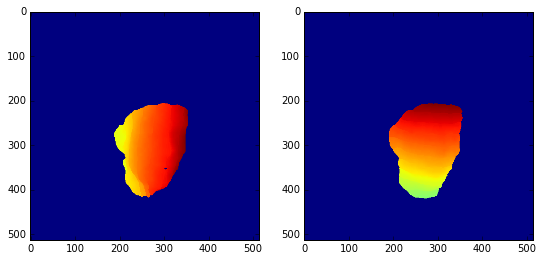

In [16]:

# Load and resizethe image.
I = np.array( Image.open("TestImages/lena.png") )
New_size_x = np.int(8 * np.round(I.shape[0]/8.) + 1)
New_size_y = np.int(8 * np.round(I.shape[1]/8.) + 1)
I_resized = imresize(I,[New_size_x,New_size_y]).astype(np.float32)
# Subtract the mean value.
im = copy.deepcopy(I_resized[:,:,::-1])
im -= mean

im_input = np.transpose(im[:,:,::-1,np.newaxis], (3,2,0,1))
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
#Net is reshaped and input is set. now forward..
net.forward()

H= np.squeeze( copy.deepcopy(net.blobs['H_Out'].data[...] ) )
V= np.squeeze( copy.deepcopy(net.blobs['V_Out'].data[...] ) )

#Visualize
f, axarr = plt.subplots(1, 2, figsize=(9,8))
axarr[0].imshow(H)
axarr[1].imshow(V)


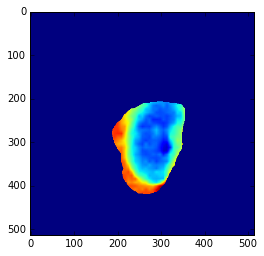

In [18]:
#### Get depth(if desired)
Z= np.squeeze( copy.deepcopy(net.blobs['Regression_Z_zoom'].data[...] ) )
Z= np.squeeze( Z[1,:,:] )
Z_index = np.squeeze( copy.deepcopy(net.blobs['Face_Z_zoom_argmax'].data[...] ) )
Depth = Z*Z_index
plt.imshow(Depth)

Interpolate the values on the template space to the image:
  - Remap the grid image to the image.
  - Remap the semantic segmentation labels to the image space.

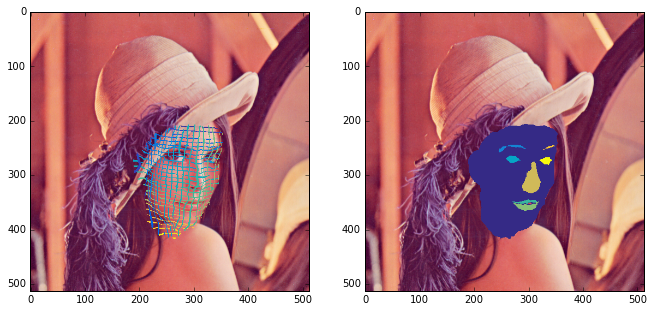

In [5]:
Grid_interpolated= cv2.remap(L_grid_color , H*330, 330 - V*330,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
Grid_interpolated[Grid_interpolated==0] =I_resized[Grid_interpolated==0]/255

Seg_interpolated= cv2.remap(L_segments_color , H*330, 330 - V*330,  interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
Seg_interpolated[Seg_interpolated==0] =I_resized[Seg_interpolated==0]/255

#visualize.
f, axarr = plt.subplots(1, 2, figsize=(11,11))
axarr[0].imshow(Grid_interpolated)
axarr[1].imshow(Seg_interpolated)

### Landmark Localization From Regressed Coordinates

Here is a function for finding the closest point on the deformation-free coordinates.

In [6]:
def get_prediction(im, h, v):
    pts = []
    n_landmarks = template_landmarks.shape[0]
    regression_result = (np.array([h, v]))
    regression_result[regression_result<0] = np.inf

    for i in range(n_landmarks):
        if i<17:
            indices = np.unravel_index(
                np.argmin(((regression_result - (template_landmarks[i][:, None, None])).transpose(1,2,0) **2).sum(2) ), regression_result.shape)
            pts.append(indices[1:])
        else:
            indices = np.unravel_index(
                np.argmin(((regression_result - (template_landmarks[i][:, None, None])).transpose(1,2,0) **2).sum(2) ), regression_result.shape)
            pts.append(indices[1:])

    return ((np.array(pts)))

Landmarks are visualized:

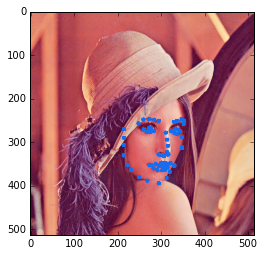

In [7]:
pred = get_prediction(I_resized, H, V)
#Visualize
canvas = I_resized.copy()
for i in np.arange(pred.shape[0]):
    cv2.circle(canvas, (int(pred[i, 1]), int(pred[i, 0])), 5, (24,109,238), -1)
plt.imshow(canvas/255)